## Ivan Barros, Grasielly Lima

# Introdução

Este projeto tem como objetivo fornecer uma análise detalhada e abrangente dos dados de partidas de futebol da temporada atual da Premier League, com foco específico no número de escanteios. Utilizando técnicas de automação para coleta de dados e processamento inteligente (utilizando playwright e pandas para coletar e organizar dados de estatísticas de jogadores de futebol), buscamos extrair insights valiosos tanto na visão agrupada por clubes. Esta abordagem nos permitirá entender melhor os padrões e as tendências associadas aos escanteios, bem como suas interações e correlações com outras variáveis relevantes no contexto do futebol.

# Problema

A análise do número de escanteios em partidas de futebol é uma área de interesse tanto para analistas esportivos quanto para treinadores e jogadores. No entanto, a obtenção e processamento desses dados de forma eficiente pode ser desafiador devido ao volume e complexidade das informações disponíveis. 

Nosso objetivo é resolver este problema coletando dados estatísticos detalhados de jogadores e equipes a partir de fontes confiáveis, organizando e analisando essas informações para identificar padrões significativos. Especificamente, queremos:

1. **Agrupamento por Clubes**: Examinar como os diferentes clubes se comportam em termos de número de escanteios, identificando quais clubes têm maior ou menor propensão a ganhar escanteios e quais variáveis podem estar correlacionadas a isso.

Além disso, serão exploradas interações e correlações com outras variáveis, como gols, assistências, cartões, entre outros. Esta análise multifacetada permitirá uma compreensão mais completa dos fatores que influenciam o número de escanteios e como eles se relacionam com o desempenho geral da equipe e dos jogadores.

# Extração de dados

O script navega até páginas web, extrai informações relevantes e organiza esses dados em um formato estruturado para posterior análise. Foram utilizadas as bibliotecas `playwright` para navegação web automatizada e `pandas` para manipulação de dados. O objetivo do projeto é extrair dados de desempenho de jogadores do site [Opta](https://optaplayerstats.statsperform.com/) (utilizado como fonte de informação para diversas casas de apostas conhecidas no mercado nacional) e organizar esses dados em um formato estruturado para análise.

### Dependências

O projeto utiliza as seguintes bibliotecas Python:
- `pandas` para manipulação de dados
- `playwright` para navegação web automatizada
- `time` para pausas controladas durante a execução do script

```python
import pandas as pd
from playwright.sync_api import sync_playwright
import time
import os
```

# Extração de dados

### Funções Principais
1. get_match_page_hrefs

Essa função navega até uma página de resultados de jogos e coleta os links para as páginas individuais de cada partida.

```python
def get_match_page_hrefs(page_url):
    with sync_playwright() as p:
        browser = p.chromium.launch(executable_path="/usr/bin/google-chrome", headless=False)
        page = browser.new_page()

        try:
            page.goto(page_url)
            page.wait_for_load_state("networkidle")

            match_page_hrefs = page.query_selector_all("a.Opta-MatchLink")
            hrefs = []
            if match_page_hrefs:
                for match_page_href in match_page_hrefs:
                    hrefs.append(match_page_href.get_attribute("href"))
            else:
                print("No Match Page hrefs found.")
            return hrefs

        except Exception as e:
            print("Error:", e)

        finally:
            browser.close()
```

2. scrape_stats

Essa função extrai as estatísticas dos jogadores de uma página específica de partida. Ela coleta os nomes dos jogadores e suas respectivas estatísticas, bem como os nomes dos clubes envolvidos na partida.

```python
def scrape_stats(page):
    headers = page.query_selector_all('.Opta-Player-Stats th.Opta-Stat abbr')
    header_names = [header.inner_text() for header in headers]

    rows = page.query_selector_all('tbody tr')
    data_dict = {header_name: [] for header_name in header_names}
    data_dict['Player'] = []
    for row in rows:
        player_name_element = row.query_selector('th.Opta-Player')
        if player_name_element:
            player_name = player_name_element.inner_text()
            if player_name != 'Total':
                stats = [cell.inner_text() for cell in row.query_selector_all('.Opta-Stat')]
                data_dict['Player'].append(player_name)
                for header_name, stat in zip(header_names, stats):
                    data_dict[header_name].append(stat)

    team_elements = page.query_selector_all('ul.Opta-Cf')

    clubs = []

    for team_element in team_elements:
        club_list_items = team_element.query_selector_all('li:not(.Opta-On) a')
        for item in club_list_items:
            club = item.inner_text()
            clubs.append(club)

    game_dict = {'Team': [1, 0], 'Club': clubs[0:2]}

    return data_dict, game_dict
```

3. load_players_clubs

Carrega um arquivo Excel contendo a relação entre jogadores e seus respectivos clubes. Retorna um dicionário onde a chave é o nome do jogador e o valor é o nome do clube.

```python
def load_players_clubs(file_path):
    players_df = pd.read_excel(file_path)
    players_clubs = dict(zip(players_df['Player'], players_df['Club']))
    return players_clubs
```

4. process_page

Essa função processa uma página de partida específica, extrai as estatísticas dos jogadores, associa cada jogador ao seu clube e time (casa ou visitante) e retorna um DataFrame organizado.

```python
def process_page(page_url, players_clubs):
    with sync_playwright() as p:
        browser = p.chromium.launch(executable_path="/usr/bin/google-chrome", headless=False)
        page = browser.new_page()
        page.goto(page_url)
        time.sleep(5)
        data_dict, game_dict = scrape_stats(page)
        browser.close()

    df = pd.DataFrame(data_dict)
    player_col = df.pop('Player')
    df.insert(0, 'Player', player_col)

    df = df.head(len(df) // 2)

    length_df = len(df)

    df_team_club = pd.DataFrame({'Team': [None] * length_df, 'Club': [None] * length_df})

    for idx, player in enumerate(df['Player']):
        if player in players_clubs:
            club = players_clubs[player]
            try:
                team_index = game_dict['Club'].index(club)
                team = game_dict['Team'][team_index]
            except ValueError:
                # Se o clube não estiver presente no game_dict, deixe em branco
                team = ''
            df_team_club.loc[idx, 'Club'] = club
            df_team_club.loc[idx, 'Team'] = team


    # Drop rows with missing club information
    df_team_club = df_team_club.dropna()

    # Merge the data frames
    df = pd.concat([df, df_team_club], axis=1)

    return df

Função Principal main

Essa função principal orquestra o fluxo do script, carregando a lista de jogadores e clubes, obtendo os links das páginas de partidas, processando cada página de partida e salvando os dados coletados em arquivos CSV.

```python
def main():
    players_clubs = load_players_clubs("players_list.xlsx")

    page_url_1 = "https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/results"
    hrefs = get_match_page_hrefs(page_url_1)

    for idx, href in enumerate(hrefs, start=1):
        print(f"Processing {href}...")
        df = process_page(href, players_clubs)
        if len(df) > 21:
            csv_filename = f"csvs/match_{idx}_stats.csv"
            df.to_csv(csv_filename)
            print(df)
            print("Ok")
        else:
            print("Skipped - Number of rows in DataFrame is not the minimum.")

if __name__ == "__main__":
    main()

## Execução do Código explicado acima

In [66]:
# Código para instalar as dependências listadas em requirements.txt
!pip install -r requirements.txt

In [68]:
# Código para executar o arquivo extrac_data.py
!python extrac_data.py

Processing https://optaplayerstats.statsperform.com/en_GB/soccer/premier-league-2023-2024/1jt5mxgn4q5r6mknmlqv5qjh0/match/view/er8a46kqojgwtslqc8k3827f8...
Traceback (most recent call last):
  File "/home/ivan/Documentos/webscrabs/extrac_data.py", line 122, in <module>
    main()
  File "/home/ivan/Documentos/webscrabs/extrac_data.py", line 113, in main
    df = process_page(href, players_clubs)
  File "/home/ivan/Documentos/webscrabs/extrac_data.py", line 71, in process_page
    data_dict, game_dict = scrape_stats(page)
  File "/home/ivan/Documentos/webscrabs/extrac_data.py", line 30, in scrape_stats
    headers = page.query_selector_all('.Opta-Player-Stats th.Opta-Stat abbr')
  File "/home/ivan/Documentos/webscrabs/venv/lib/python3.10/site-packages/playwright/sync_api/_generated.py", line 6239, in query_selector_all
    self._sync(
  File "/home/ivan/Documentos/webscrabs/venv/lib/python3.10/site-packages/playwright/_impl/_sync_base.py", line 111, in _sync
    return task.result()
  F

Disclaimer: o código acima demora bastante para ser rodado. 

# Análise

## Abordagem Clubes

Inicialmente, trabalharemos com uma abordagem visando analisar o parâmetro de escanteios dentro dum agrupamento por clubes.

### Dependências

In [69]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

O código abaixo realiza a leitura, processamento e análise de dados de arquivos CSV que contêm estatísticas de partidas de futebol, agrupando os dados por clubes e times. 

1. Listagem de Arquivos CSV: O código começa listando todos os arquivos CSV presentes no diretório csvs.

2. Inicialização do DataFrame: Um DataFrame vazio dados_clubes é criado para armazenar os dados processados.

3. Leitura e Processamento dos Arquivos CSV:
    - Para cada arquivo CSV listado, o caminho completo do arquivo é gerado.
    - Os dados são lidos do arquivo CSV e linhas com valores ausentes são removidas.
    - Os dados são agrupados por "Club" e "Team" e somados.
    - As colunas de estatísticas são renomeadas para indicar que são valores conquistados pelos times (_Pro).
    - Uma cópia do DataFrame é criada para calcular os valores cedidos (_Against) para cada time.
    - As colunas são reordenadas para separar claramente os valores de times jogando em casa ou e fora de casa.
    - O DataFrame processado é concatenado ao DataFrame principal dados_clubes.

In [70]:
arquivos_csv = [arquivo for arquivo in os.listdir('csvs') if arquivo.endswith('.csv')]

dados_clubes = pd.DataFrame()

for arquivo in arquivos_csv:
    caminho_completo = os.path.join('csvs', arquivo)  # Gera o caminho completo do arquivo
    dados = pd.read_csv(caminho_completo)  # Usa o caminho completo para ler o arquivo
    dados = dados.dropna()

    df_grouped = dados.drop(columns=["Player"]).groupby(["Club", "Team"]).sum().reset_index()

    df_grouped.rename(columns={col: col + "_Pro" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]}, inplace=True)

    df_grouped_against = df_grouped.copy()

    for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]:
        df_grouped_against[col + "_Against"] = df_grouped[col + "_Pro"].sum() - df_grouped[col + "_Pro"]

    columns_order = ["Club", "Team"] + [col + "_Pro" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]] + [col + "_Against" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]]
    df_grouped_against = df_grouped_against[columns_order]

    dados_clubes = pd.concat([dados_clubes, df_grouped_against], ignore_index=True)

dados_clubes.reset_index(drop=True, inplace=True)

dados_clubes.head(6)

,Club,Team,G_Pro,A_Pro,RC_Pro,YC_Pro,Crn_Pro,S_Pro,SOnT_Pro,BS_Pro,...,Crn_Against,S_Against,SOnT_Against,BS_Against,P_Against,C_Against,Tk_Against,O_Against,FC_Against,FW_Against
0,Crystal Palace FC,0.0,0,0,0,3,8,11,1,3,...,5,8,6,0,423,8,5,0,5,7
1,Newcastle United FC,1.0,3,2,0,1,5,8,6,0,...,8,11,1,3,262,11,16,1,11,5
2,Liverpool FC,0.0,1,1,0,1,9,19,2,9,...,2,7,2,2,274,10,19,2,11,10
3,Nottingham Forest FC,1.0,0,0,0,3,2,7,2,2,...,9,19,2,9,620,19,19,1,8,9
4,AFC Bournemouth,1.0,0,0,0,1,7,8,1,6,...,5,14,7,4,519,16,30,0,12,9
5,Liverpool FC,0.0,4,4,0,2,5,14,7,4,...,7,8,1,6,301,15,24,1,8,11


4. Separação dos Dados:

    - Os dados das estatisticas conquistadas (_Pro) são separados das estatísticas cedidas dos times (_Against).
    - As colunas dos DataFrames separados são renomeadas para remover os sufixos _Pro e _Against.

In [71]:
dados_clubes_pro = dados_clubes.iloc[:, :16]
dados_clubes_against = pd.concat([dados_clubes.iloc[:, :2], dados_clubes.iloc[:, -14:]], axis=1)

# Renomeando as colunas do dataframe dados_clubes_pro
dados_clubes_pro.columns = [col.replace('_Pro', '') for col in dados_clubes_pro.columns]

# Renomeando as colunas do dataframe dados_clubes_against
dados_clubes_against.columns = [col.replace('_Against', '') for col in dados_clubes_against.columns]


Resultado

Após a execução desse trecho de código, temos dois DataFrames principais:

    dados_clubes_pro: Contém as estatísticas conquistadas de cada clube.
    dados_clubes_against: Contém as estatísticas cedidas cada clube.

- Em que, por exemplo, num jogo entre Náutico e Sport, em que o Náutico teve 8 escanteios a favor e o Sport teve 2 a favor:

    - Náutico: Crn_Pro = 8, Crn_Against = 2.


A função plot_media_por_clube abaixo é utilizada para criar um gráfico de barras que mostra a média de um indicador específico para cada clube, separando os dados por "Team", em que Team = 1 significa que o clube jogou em casa e Team = 0 significa que o clube jogou fora de casa. 

In [83]:
def plot_media_por_clube(df, variable):
    # Calculando a média de cada indicador para cada clube, separando por Team = 0 e Team = 1
    media_por_clube = df.groupby(['Club', 'Team']).mean().unstack()

    # Plotando o gráfico de barras
    fig, ax = plt.subplots(figsize=(15, 8))

    # Definindo a largura das barras
    bar_width = 0.35

    # Definindo as posições das barras
    posicoes = range(len(media_por_clube))

    # Selecionando os dados para Team = 0
    media_team_0 = media_por_clube.loc[:, (variable, 0)].values

    # Selecionando os dados para Team = 1
    media_team_1 = media_por_clube.loc[:, (variable, 1)].values

    # Plotando as barras para Team = 0
    bars_team_0 = ax.bar(posicoes, media_team_0, bar_width, label=f'{variable} Team 0')

    # Plotando as barras para Team = 1
    bars_team_1 = ax.bar([p + bar_width for p in posicoes], media_team_1, bar_width, label=f'{variable} Team 1')

    # Adicionando rótulos de valor nas barras para Team = 0
    for bar in bars_team_0:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize = 8)

    # Adicionando rótulos de valor nas barras para Team = 1
    for bar in bars_team_1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize = 8)

    # Definindo os rótulos do eixo x como os clubes
    ax.set_xticks([p + bar_width / 2 for p in posicoes])
    ax.set_xticklabels(media_por_clube.index)

    # Adicionando legendas, título e rótulos dos eixos
    ax.legend()
    ax.set_xlabel('Clube')
    ax.set_ylabel('Média')
    ax.set_title(f'Média de {variable} para cada clube, separado por Team')

    # Exibindo o gráfico
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


Vamos analisar abaixo a média dos escanteios conquistados ao longo do campeonato. Sendo a coluna azul a média dos escanteios conquistados fora de casa e a coluna laranja a média dos escanteios conquistados em casa.

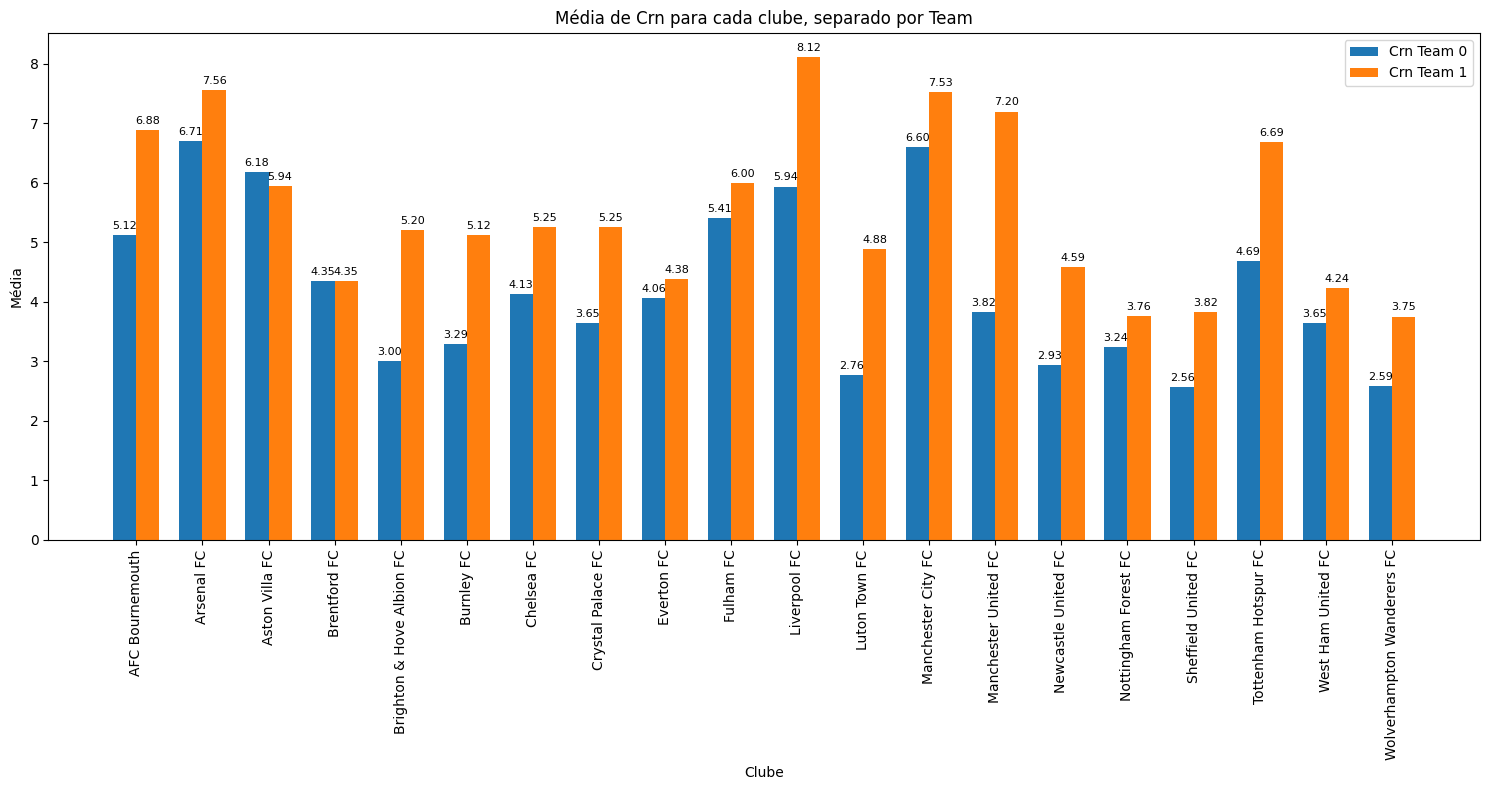

In [84]:
plot_media_por_clube(dados_clubes_pro, 'Crn')

##### Descrição dos Dados

Os dados representam a média de escanteios conquistados por cada equipe no campeonato, segmentados por jogos fora de casa (Team = 0) e jogos em casa (Team = 1).

##### Análise Detalhada

- Diferença Entre Jogos em Casa e Fora de Casa:
    
    - Liverpool FC e Arsenal FC se destacam como os times que mais conquistam escanteios em casa, com médias de 8.117647 e 7.562500, respectivamente. Isso pode indicar uma estratégia ofensiva mais agressiva quando jogam com o apoio da torcida.
    - Liverpool FC também apresenta uma alta média fora de casa (5.937500), sugerindo consistência ofensiva independentemente do local do jogo.
    - Manchester United FC e Manchester City FC têm uma diferença significativa entre os jogos em casa e fora de casa, conquistando bem mais escanteios em casa. Para Manchester United FC, a média em casa é de 7.200000 comparada com 3.823529 fora. Para Manchester City FC, as médias são 7.529412 em casa e 6.600000 fora.

- Consistência entre Casa e Fora:
    - Brentford FC tem a mesma média de escanteios conquistados em casa e fora de casa (4.352941). Isso pode indicar uma abordagem tática estável e consistente.
    - Newcastle United FC e Everton FC apresentam médias relativamente próximas entre jogos em casa e fora, sugerindo uma abordagem equilibrada em ambos os cenários.

- Desempenho Ofensivo de Clubes Menores:
    - Luton Town FC e Wolverhampton Wanderers FC têm médias mais baixas, especialmente fora de casa, com 2.764706 e 2.588235, respectivamente. Isso pode indicar dificuldades em criar oportunidades ofensivas fora de seus domínios.

- Outliers Positivos:
    - Liverpool FC é um outlier positivo em casa com uma média de 8.117647 escanteios, muito acima da média geral, indicando uma forte presença ofensiva em casa.
    - Manchester City FC e Arsenal FC também estão entre os clubes com mais escanteios em casa, reforçando sua postura ofensiva forte em seus estádios.

##### Insights

Impacto da Localidade: A análise sugere que a localidade do jogo (casa ou fora) tem um impacto significativo na capacidade dos times de conquistar escanteios, com a maioria dos times apresentando melhores resultados em casa.

Consistência Tática: Times como Brentford FC e Everton FC mostram consistência nas suas médias de escanteios, o que pode refletir uma abordagem tática menos dependente do local do jogo.

Desempenho de Clubes Grandes: Clubes grandes como Liverpool FC, Manchester City FC, e Arsenal FC são consistentemente melhores em casa, o que pode ser explorado como uma vantagem estratégica nos jogos.

Vamos analisar abaixo a média dos escanteios cedidos ao longo do campeonato. Sendo a coluna azul a média dos escanteios cedidos fora de casa e a coluna laranja a média dos escanteios cedidos em casa.

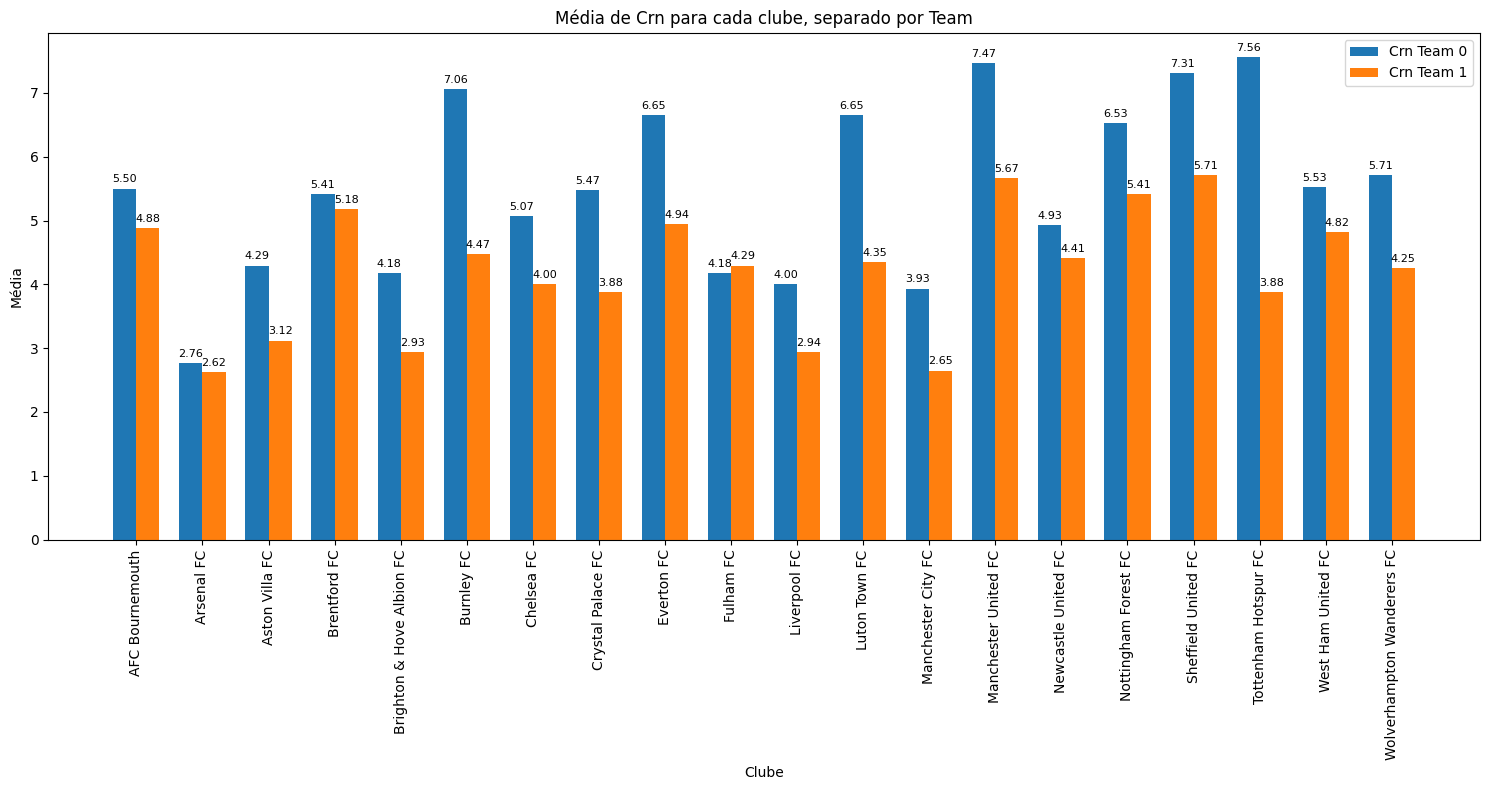

In [85]:
plot_media_por_clube(dados_clubes_against, 'Crn')

##### Descrição dos Dados

Os dados representam a média de escanteios cedidos por cada equipe no campeonato, segmentados por jogos fora de casa (Team = 0) e jogos em casa (Team = 1).
Análise Detalhada

##### Analise detalhada

- Diferença Entre Jogos em Casa e Fora de Casa:
    - Tottenham Hotspur FC e Manchester United FC cedem significativamente mais escanteios fora de casa, com médias de 7.562500 e 7.470588, respectivamente, comparado com 3.875000 e 5.666667 em casa. Isso pode indicar dificuldades defensivas em jogos fora de seus estádios.
    - Burnley FC também cede muitos escanteios fora de casa (7.058824), mas consegue reduzir essa média em jogos em casa (4.470588).

- Defesa Sólida em Casa:
    - Arsenal FC e Liverpool FC cedem poucas oportunidades de escanteios quando jogam em casa, com médias de 2.625000 e 2.941176, respectivamente. Essa solidez defensiva é uma vantagem significativa.
    - Manchester City FC também mostra uma forte defesa em casa, cedendo uma média de 2.647059 escanteios.

- Inconsistências Defensivas:
    - Nottingham Forest FC e Sheffield United FC têm médias altas tanto em casa quanto fora, indicando problemas defensivos mais abrangentes. Sheffield United FC cede em média 7.312500 escanteios fora e 5.705882 em casa.

- Outliers Negativos:
    - Tottenham Hotspur FC é um outlier negativo fora de casa, cedendo a maior média de escanteios (7.562500), o que pode ser explorado pelos adversários em suas estratégias ofensivas.
    - Manchester United FC também se destaca negativamente fora de casa, cedendo 7.470588 escanteios, sugerindo uma vulnerabilidade defensiva.

##### Insights

Impacto da Localidade: Semelhante à análise de escanteios conquistados, a localidade tem um impacto notável na defesa dos times. A maioria dos times cede menos escanteios em casa.
    
Sólidas Defesas em Casa: Clubes como Arsenal FC, Liverpool FC, e Manchester City FC destacam-se por cederem poucos escanteios em casa, sugerindo uma defesa sólida e bem organizada em seus estádios.

Vulnerabilidades Fora de Casa: Times como Tottenham Hotspur FC e Manchester United FC mostram claras vulnerabilidades defensivas fora de casa, o que pode ser uma área de foco para melhoria.

#### Correlação com outras variáveis

In [95]:
def correlacao_por_clube(dataframe, team):
    df_team = dataframe[dataframe['Team'] == team]
    
    correlation_matrix = df_team.iloc[:, 2:].corr()
    
    return correlation_matrix

matriz_correlacao = correlacao_por_clube(dados_clubes_pro, 1)

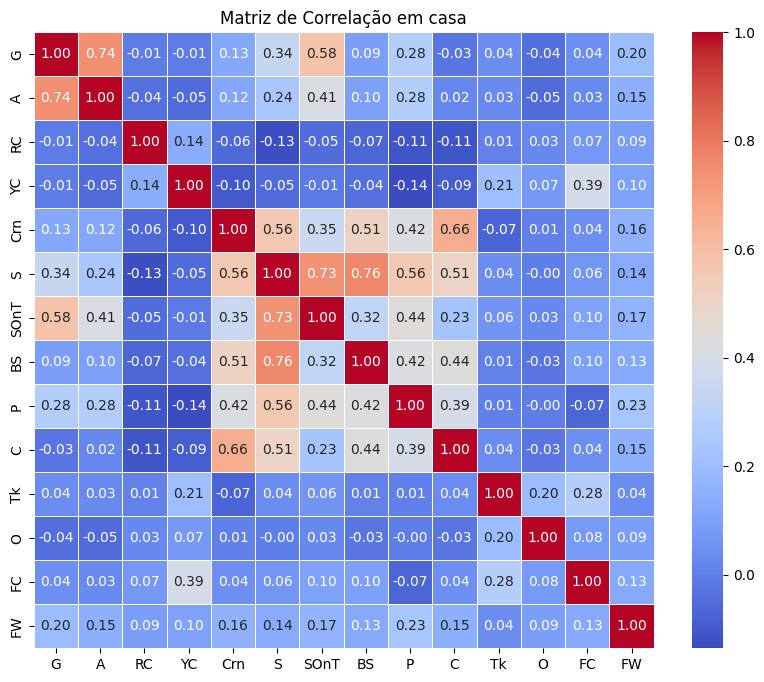

In [96]:
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação em casa')
plt.show()

- Corners Won (Crn) em casa

Correlação Positiva Forte:

    Crosses (C): 0.6552
    Shots (S): 0.5602
    Blocked Shots (BS): 0.5143
    Passes (P): 0.4170

Correlação Moderada:

    Shots on Target (SOnT): 0.3511

Correlação Fraca ou Nula:

    Goals (G): 0.1260
    Assists (A): 0.1193

Insight: A alta correlação entre escanteios conquistados e cruzamentos sugere que equipes que utilizam cruzamentos como parte de sua estratégia ofensiva tendem a conquistar mais escanteios. A relação com chutes e chutes bloqueados também indica que escanteios podem resultar de tentativas ofensivas frequentes.

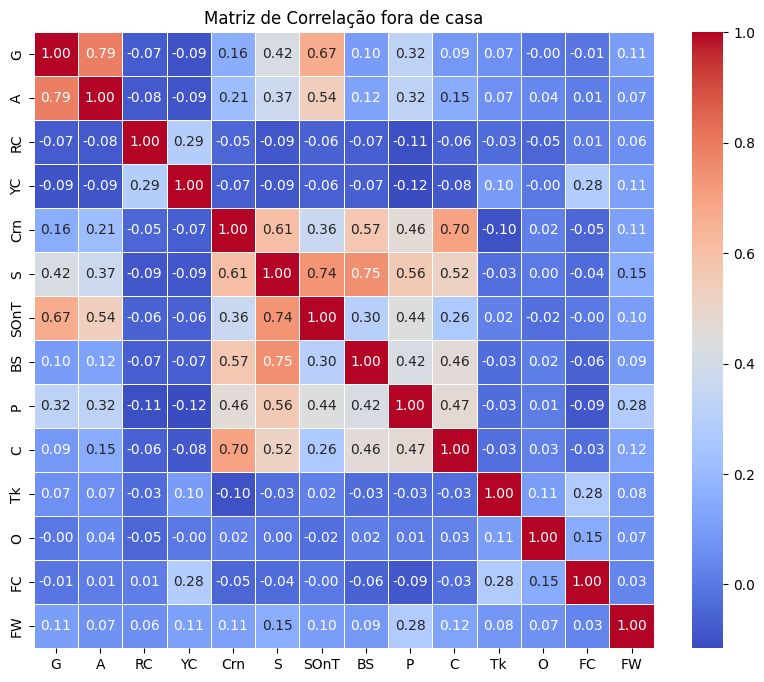

In [97]:
matriz_correlacao_0 = correlacao_por_clube(dados_clubes_pro, 0)

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao_0, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação fora de casa')
plt.show()

- Corners Won (Crn) fora de casa

    Chutes (S) e Chutes no Alvo (SOnT): Correlações positivas (0.607 e 0.363), indicando que escanteios geram boas oportunidades de chute.

    Bloqueios (BS) e Passes (P): Correlações moderadas a altas (0.569 e 0.464), sugerindo uma conexão entre escanteios, movimentação de bola e tentativas de gol.

    Cruzamentos (C): Correlação alta (0.698), destacando a importância dos cruzamentos em situações de escanteio.

## Conclusão

### Conclusão sobre os Resultados dos Escanteios Conquistados e Cedidos

A análise detalhada dos escanteios conquistados e cedidos pelos times de futebol revela várias tendências importantes relacionadas ao desempenho em casa e fora de casa:

1. **Impacto da Localidade**:
   - A localidade do jogo tem um impacto significativo tanto na capacidade de conquistar quanto de ceder escanteios.
   - A maioria dos times conquista mais escanteios e cede menos quando jogam em casa, beneficiando-se do apoio da torcida e da familiaridade com o campo.

2. **Desempenho Ofensivo**:
   - **Clubes Grandes**: Times como Liverpool FC, Manchester City FC e Arsenal FC têm médias altas de escanteios conquistados em casa, destacando sua postura ofensiva agressiva. Liverpool FC, em particular, mostra consistência ao manter uma alta média de escanteios fora de casa também.
   - **Clubes Menores**: Equipes como Luton Town FC e Wolverhampton Wanderers FC têm dificuldades em criar oportunidades ofensivas, especialmente fora de casa, refletidas em suas baixas médias de escanteios.

3. **Consistência Tática**:
   - Alguns times, como Brentford FC e Everton FC, mostram consistência em suas médias de escanteios conquistados tanto em casa quanto fora, sugerindo uma abordagem tática estável e menos dependente da localidade do jogo.

4. **Desempenho Defensivo**:
   - **Defesa Sólida em Casa**: Clubes como Arsenal FC, Liverpool FC e Manchester City FC cedem poucos escanteios em casa, demonstrando uma defesa bem organizada.
   - **Vulnerabilidades Fora de Casa**: Times como Tottenham Hotspur FC e Manchester United FC mostram vulnerabilidades defensivas significativas fora de casa, cedendo mais escanteios, o que pode ser explorado pelos adversários.

5. **Inconsistências Defensivas**:
   - Equipes como Nottingham Forest FC e Sheffield United FC apresentam problemas defensivos mais abrangentes, com médias altas de escanteios cedidos tanto em casa quanto fora.

### Insights

- **Estratégia Ofensiva e Defensiva**:
  - Clubes podem usar a vantagem de jogar em casa para reforçar suas estratégias ofensivas, sabendo que tendem a conquistar mais escanteios.
  - Melhorar a defesa fora de casa pode ser crucial para times com vulnerabilidades, como Tottenham Hotspur FC e Manchester United FC.

- **Aproveitamento de Oportunidades**:
  - Adversários podem explorar a fraqueza defensiva dos times que cedem muitos escanteios fora de casa, ajustando suas estratégias ofensivas para maximizar as chances de gol a partir de escanteios.

### Conclusão sobre a Correlação entre Escanteios Conquistados (Crn) em Casa e Fora de Casa

#### Correlações Positivas Fortes e Moderadas

**Em Casa:**
- **Cruzamentos (C): 0.6552**
- **Chutes (S): 0.5602**
- **Chutes Bloqueados (BS): 0.5143**
- **Passes (P): 0.4170**
- **Chutes no Alvo (SOnT): 0.3511**

**Fora de Casa:**
- **Cruzamentos (C): 0.698**
- **Chutes (S): 0.6065**
- **Chutes no Alvo (SOnT): 0.3634**
- **Chutes Bloqueados (BS): 0.5694**
- **Passes (P): 0.4643**

### Análise Comparativa

1. **Cruzamentos (C):**
   - **Em Casa**: 0.6552
   - **Fora de Casa**: 0.698
   - **Conclusão**: Em ambos os cenários, há uma forte correlação entre cruzamentos e escanteios conquistados, ligeiramente maior fora de casa. Isso sugere que as equipes que utilizam cruzamentos de forma consistente tendem a gerar mais escanteios independentemente de onde jogam, embora o efeito seja um pouco mais pronunciado fora de casa.

2. **Chutes (S):**
   - **Em Casa**: 0.5602
   - **Fora de Casa**: 0.6065
   - **Conclusão**: A correlação entre chutes e escanteios é forte tanto em casa quanto fora, sendo ligeiramente maior fora de casa. Isso indica que equipes que chutam mais ao gol tendem a conquistar mais escanteios, com essa tendência sendo um pouco mais acentuada quando jogam fora.

3. **Chutes Bloqueados (BS):**
   - **Em Casa**: 0.5143
   - **Fora de Casa**: 0.5694
   - **Conclusão**: A correlação moderada a alta entre chutes bloqueados e escanteios em ambos os cenários sugere que tentativas ofensivas bloqueadas frequentemente resultam em escanteios, com um impacto um pouco maior fora de casa.

4. **Passes (P):**
   - **Em Casa**: 0.4170
   - **Fora de Casa**: 0.4643
   - **Conclusão**: Passes têm uma correlação moderada com escanteios em ambos os cenários, ligeiramente maior fora de casa. Isso pode indicar que uma boa circulação da bola contribui para a criação de oportunidades que resultam em escanteios, com um efeito um pouco mais significativo fora de casa.

5. **Chutes no Alvo (SOnT):**
   - **Em Casa**: 0.3511
   - **Fora de Casa**: 0.3634
   - **Conclusão**: A correlação entre chutes no alvo e escanteios é moderada em ambos os cenários, sendo um pouco maior fora de casa. Isso sugere que chutes precisos ajudam a criar situações de escanteio, com um impacto ligeiramente mais forte fora de casa.

### Insight Geral

A correlação forte entre cruzamentos e escanteios, tanto em casa quanto fora, destaca a importância dos cruzamentos como uma estratégia ofensiva eficaz para conquistar escanteios. A relação com chutes e chutes bloqueados reforça que equipes que pressionam ofensivamente e tentam finalizações frequentes tendem a ganhar mais escanteios.

**Diferenças Chave:**
- As correlações são consistentemente mais fortes fora de casa do que em casa para cruzamentos, chutes, chutes no alvo, chutes bloqueados e passes. Isso sugere que quando as equipes jogam fora, suas tentativas ofensivas, movimentação de bola e estratégias de cruzamento são ainda mais cruciais para conquistar escanteios.

**Conclusão:**
Para maximizar a conquista de escanteios, especialmente fora de casa, as equipes devem focar em estratégias que enfatizem cruzamentos e finalizações frequentes. A manutenção de uma boa circulação de bola também é importante para criar oportunidades que resultam em escanteios.

# Previsão muito louca

Para prever a quantidade de escanteios que acontecerão em uma partida entre dois clubes, desenvolvemos um modelo preditivo simples que utiliza a média histórica de escanteios conquistados e cedidos por cada equipe. Este modelo baseia-se em dados históricos dos clubes jogando em casa e fora, e calcula uma média ponderada para estimar os escanteios em uma partida específica.

O código a seguir implementa uma função chamada print_media_por_clubes, que calcula e exibe as médias de escanteios para dois clubes com base em seus desempenhos históricos. A função realiza os seguintes passos:

Passos do Código:

- Filtragem de Dados:
    - Os dados são filtrados para obter as médias de escanteios conquistados e cedidos pelo primeiro clube (club1) quando jogando em casa (Team = 1).
    - Da mesma forma, os dados são filtrados para obter as médias de escanteios conquistados e cedidos pelo segundo clube (club2) quando jogando fora de casa (Team = 0).

- Cálculo das Médias:
    - Para club1, a média de escanteios conquistados em casa (media_club1_team1_pro) e a média de escanteios cedidos em casa (media_club1_team1_against) são calculadas.
    - Para club2, a média de escanteios conquistados fora de casa (media_club2_team0_pro) e a média de escanteios cedidos fora de casa (media_club2_team0_against) são calculadas.

- Exibição dos Resultados:
    - As médias calculadas são impressas para ambos os clubes, mostrando o desempenho esperado em termos de escanteios.
    - É calculada uma média ponderada (media_home e media_out) para prever os escanteios que cada clube pode conquistar na partida. Esta média é baseada nas médias de escanteios conquistados e cedidos.

- Impressão das Predições:
    - Finalmente, as predições de escanteios para club1 e club2 são impressas, mostrando os valores estimados de escanteios para a partida.

In [98]:
def print_media_por_clubes(club1, club2):
    # Filtrando os dados para o primeiro clube e Team = 1
    media_club1_team1_pro = dados_clubes_pro.loc[(dados_clubes_pro['Club'] == club1) & (dados_clubes_pro['Team'] == 1), 'Crn'].mean()
    media_club1_team1_against = dados_clubes_against.loc[(dados_clubes_against['Club'] == club1) & (dados_clubes_against['Team'] == 1), 'Crn'].mean()
    
    # Filtrando os dados para o segundo clube e Team = 0
    media_club2_team0_pro = dados_clubes_pro.loc[(dados_clubes_pro['Club'] == club2) & (dados_clubes_pro['Team'] == 0), 'Crn'].mean()
    media_club2_team0_against = dados_clubes_against.loc[(dados_clubes_against['Club'] == club2) & (dados_clubes_against['Team'] == 0), 'Crn'].mean()
    
    # Imprimindo os valores de média
    print(f'{club1} costuma fazer em casa: {media_club1_team1_pro:.2f} e {club2} costuma ceder fora de casa {media_club2_team0_against:.2f}:')
    print(f'{club2} costuma fazer fora de casa: {media_club2_team0_pro:.2f} e {club1} costuma ceder em casa {media_club1_team1_against:.2f}:\n')

    media_home = (media_club1_team1_pro + media_club2_team0_against)/2
    media_out = (media_club2_team0_pro + media_club1_team1_against)/2

    print(f'se a gente for fazer uma média muito louca, {club1} vai fazer: {media_home:.2f} e {club2} vai fazer: {media_out:.2f}:')


Agora podemos testar com um jogo aleatório:

In [99]:
print_media_por_clubes('Manchester United FC', 'Sheffield United FC')

Manchester United FC costuma fazer em casa: 7.20 e Sheffield United FC costuma ceder fora de casa 7.31:
Sheffield United FC costuma fazer fora de casa: 2.56 e Manchester United FC costuma ceder em casa 5.67:

se a gente for fazer uma média muito louca, Manchester United FC vai fazer: 7.26 e Sheffield United FC vai fazer: 4.11:


Finalmente, é só entrar no seu site de apostas favorito e tentar a sorte (ou melhor, ciência) com essa predição!